In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
from statsmodels.sandbox.stats.runs import runstest_1samp
import statistics as s
from sklearn.preprocessing import MinMaxScaler, normalize
from scipy.stats import chi2_contingency, pearsonr
from pandasql import sqldf
from collections import OrderedDict
import os
import geopandas as gp
from shapely.geometry import Point
import requests
from bs4 import BeautifulSoup
import contextily as ctx

F:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Preprocessing Datasets

## Airbnb Listings & Reviews

In [2]:
dir_ = 'D:/Computational Thinking and DS/HW1 8.22-8.26/data_airbnb'
os.chdir(dir_)

In [3]:
listing = pd.read_csv('Listings.csv', encoding = 'latin1')
review = pd.read_csv('Reviews.csv', encoding = 'latin1')

raw_listing = listing.copy()
raw_review = review.copy()

<ipython-input-3-98ff1cfd470c>:1: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  listing = pd.read_csv('Listings.csv', encoding = 'latin1')


In [4]:
raw_listing.sort_values('listing_id').head()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
85045,2577,Loft for 4 by Canal Saint Martin,2827,2008-09-09,"Casablanca, Grand Casablanca, Morocco",a few days or more,0.00,0.67,f,2.0,...,3,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t
37163,2595,Skylit Midtown Castle,2845,2008-09-09,"New York, New York, United States",within a few hours,0.93,0.26,f,6.0,...,30,1125,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f
105556,2737,"Elif's room in cozy, clean flat.",3047,2008-09-18,"Rome, Lazio, Italy",within a day,1.00,0.00,f,5.0,...,7,1125,96.0,9.0,9.0,10.0,10.0,9.0,9.0,f
159807,2903,Stay a night in Calisto6 B&B Rome,3280,2008-09-28,"Rome, Lazio, Italy",within a few hours,1.00,1.00,f,3.0,...,1,730,86.0,9.0,9.0,9.0,9.0,9.0,9.0,f
227261,3079,Cozy apartment (2-4)with Colisseum view,3504,2008-10-08,"Rome, Lazio, Italy",NaN,NaN,0.67,f,7.0,...,3,120,88.0,8.0,9.0,9.0,10.0,10.0,9.0,f


To check the overall conditions and null values, wrap functions up to summarize.

In [5]:
def overall_cond(df):
    # 1 Summary
    df.info()
    
    # 2 Empty Values
    n_null = df.isnull().sum().values
    
    with_null = n_null[n_null > 0]
    
    # 3 Histogram for empty values
    if sum(with_null) > 0:
        labels = list(df.columns[n_null > 0])
        plt.figure(figsize = (20, 10))
        plt.bar(labels, with_null, linewidth = 10)
        plt.xticks(rotation = 40)
        plt.title('Null Values')
    else: print('There is no empty values in the table.')
    return

### Listing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   279712 non-null  int64  
 1   name                         279539 non-null  object 
 2   host_id                      279712 non-null  int64  
 3   host_since                   279547 non-null  object 
 4   host_location                278872 non-null  object 
 5   host_response_time           150930 non-null  object 
 6   host_response_rate           150930 non-null  float64
 7   host_acceptance_rate         166625 non-null  float64
 8   host_is_superhost            279547 non-null  object 
 9   host_total_listings_count    279547 non-null  float64
 10  host_has_profile_pic         279547 non-null  object 
 11  host_identity_verified       279547 non-null  object 
 12  neighbourhood                279712 non-null  object 
 13 

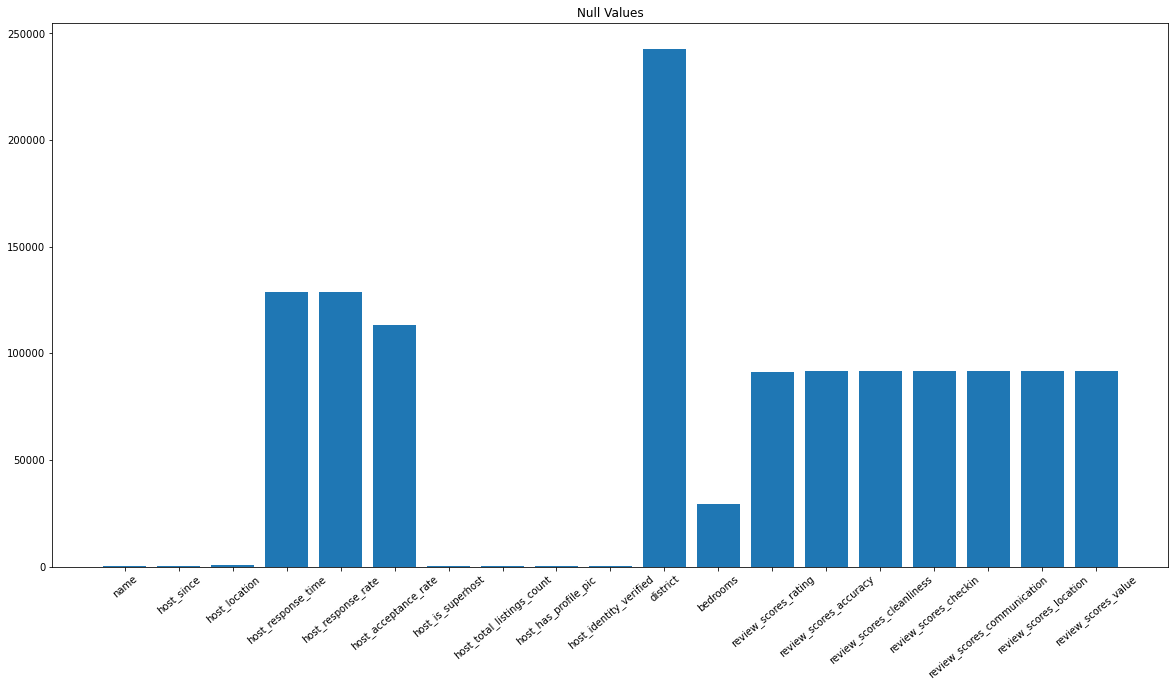

In [6]:
overall_cond(raw_listing)

### Revire Times Data

In [7]:
overall_cond(raw_review)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373143 entries, 0 to 5373142
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   listing_id   int64 
 1   review_id    int64 
 2   date         object
 3   reviewer_id  int64 
dtypes: int64(3), object(1)
memory usage: 164.0+ MB
There is no empty values in the table.


There is no empty values in the rating times data.

### Data Cleanup

I try filling nulls in rating terms (which might be due to simply skipping these scorings when writing feedbacks). Because the overall rating, 'review_scores_rating' has the least empty values, I employ this column as the main reference. 

I define a function to convert categorical columns into numerical, and calculate correlation coefficients between selected rating columns with the overall rating column.Ｉuse correlation with the overall rating to fill the nulls.

In [8]:
def choose_features(rating_features, target_feature, df):
    # For binary features
    def transtf(col):
        if col == 'f': col = 0
        elif col == 't': col = 1
        return col
            
    # For other features --------------------------------------------------------
    def transobj(dfcolumn):
        dict_val = {}
        nonull_col = dfcolumn[dfcolumn.notnull()].copy()  # Do not encode Nulls
        for i in nonull_col.index:
            if dfcolumn.iloc[i] not in dict_val.keys():
                dict_val[dfcolumn.iloc[i]] = []
            dict_val[dfcolumn.iloc[i]].append(i)
        #dict_val = OrderedDict(sorted(dict_val.items()))# Sort the keys (unique column values) alphabetically
        return dict_val
    
    # Encode features, from string type to numerical type.
    non_incld = []        
    for i in range(len(rating_features)):
        if df[df[rating_features[i]].notnull()][rating_features[i]].iloc[0] == 't' or 'f':
            df[rating_features[i]] = df[rating_features[i]].map(transtf)
        elif [df[df[rating_features[i]].notnull()][rating_features[i]].dtypes][0] == 'str' :
            dic = transobj(df[rating_features[i]])
            for j in range(len(dic.keys())):
                df.loc[dic[rating_features[i]], [rating_features[i]]] = float(j)   
        else: 
            non_incld.append(rating_features[i])   # If a selected feature does not belong to both boolean and categorical type.

    #-----------------------------------------------------------------------------
    
    
    
    rating_coefs = []

    for i in rating_features:
        extr = df[~(df[i].isnull()) & ~(df[target_feature].isnull())]
        rating_coefs.append(extr[[i, target_feature]].corr().iloc[0][1])

    dict_coef = {rating_features[i]: rating_coefs[i] for i in range(len(rating_features))}
    sorted_fnc =  sorted(dict_coef.items(), key = lambda x: x[1], reverse = True)

    
    return df, sorted_fnc, non_incld

In [9]:
rating_features = ['review_scores_checkin', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
trans_df, cor_chart, not_included = choose_features(rating_features, 'review_scores_rating', raw_listing.copy())

In [10]:
data_wiz_null = trans_df.copy()

I will choose those features with a correlation coefficient higher than 0.5 to use overall rating as the filling reference.

In [11]:
good_features = {}
for i in cor_chart:
    if i[1] >= 0.5:
        good_features[i[0]] = i[1]
good_features

{'review_scores_accuracy': 0.7858380815442485,
 'review_scores_value': 0.7828637572926817,
 'review_scores_cleanliness': 0.740594422910322,
 'review_scores_communication': 0.7094816569318649,
 'review_scores_checkin': 0.6616418897856722,
 'review_scores_location': 0.5407165299711524}

All review items to be filled are integers from 1 to 10, and 'review_scores_rating' are integers from 1 to 100. In this way, fill the values with an integer closest to $\frac{1}{10}$ 'review_scores_rating' if corresponding 'review_scores_rating' is not null. Rating values that cannot be filled will be given the highest score, 10, as usually when customers leave a score empty, they are satisfied about it.

In [12]:
raw_listing[good_features.keys()].describe()

,review_scores_accuracy,review_scores_value,review_scores_cleanliness,review_scores_communication,review_scores_checkin,review_scores_location
count,187999.000000,187927.000000,188047.000000,188025.000000,187941.000000,187937.000000
mean,9.565476,9.335364,9.312869,9.698593,9.701534,9.633994
std,0.990878,1.042625,1.146072,0.886884,0.867434,0.833234
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,9.000000,9.000000,9.000000,10.000000,10.000000,9.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [13]:
for f in good_features.keys():
    tofill = raw_listing[raw_listing[f].isnull() & raw_listing['review_scores_rating'].notnull()].index
    autofill = raw_listing[raw_listing[f].isnull() & raw_listing['review_scores_rating'].isnull()].index
    raw_listing.loc[tofill, f] = round(raw_listing.loc[tofill, 'review_scores_rating'] / 10, 0)
    raw_listing.loc[autofill, f] = 10.00
raw_listing.loc[raw_listing['review_scores_rating'].isnull(), 'review_scores_rating'] = 100.0

In [14]:
raw_listing.isnull().sum()

listing_id                          0
name                              173
host_id                             0
host_since                        165
host_location                     840
host_response_time             128782
host_response_rate             128782
host_acceptance_rate           113087
host_is_superhost                 165
host_total_listings_count         165
host_has_profile_pic              165
host_identity_verified            165
neighbourhood                       0
district                       242700
city                                0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                        29435
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
review_scores_rating                0
review_score

## Main Cities of United States

The table of main cities in US, with their geographical coordinates.

In [15]:
r = requests.get('https://www.geodatos.net/en/coordinates/united-states#:~:text=City%20Coordinates%3B%20New%20York%20City%3A%2040.71427%2C%20-74.00597%3A%20Los,Brooklyn%3A%2040.6501%2C%20-73.94958%3A%20Queens%3A%2040.68149%2C%20-73.83652%3A%20San%20Jose')
soup = BeautifulSoup(r.content, 'html.parser')
if 200 > r.status_code and 300 <= r.status_code:
    print('No access to the website.')
else:
    col = []
    for t in soup.findAll('table'):
        thead = t.find('thead').findAll('th')
        if (thead[0].string == 'City') and (thead[1].string == 'Coordinates'):
            col = [thead[0].string, 'Latitude', 'Longitude']
            city = pd.DataFrame(columns = col)
            
            tbody = t.find('tbody')
            tr = tbody.findAll('tr')
            for r in tr:
                l = len(city)
                for td in r.findAll('td'):
                    if td.string.replace(' ', '').isalpha():
                        city.loc[l, thead[0].string] = td.string
                    else:
                        city.loc[l, 'Latitude'] = float(td.string[ : td.string.find(', ')])
                        city.loc[l, 'Longitude'] = float(td.string[td.string.find(',') + 1 :])

In [16]:
city

,City,Latitude,Longitude
0,New York City,40.71427,-74.00597
1,Los Angeles,34.05223,-118.24368
2,Chicago,41.85003,-87.65005
3,Houston,29.76328,-95.36327
4,Philadelphia,39.95233,-75.16379
5,Phoenix,33.44838,-112.07404
6,San Antonio,29.42412,-98.49363
7,San Diego,32.71571,-117.16472
8,Dallas,32.78306,-96.80667
9,Brooklyn,40.6501,-73.94958


## Covid19 Data

CBSAS code of cities (https://aqs.epa.gov/aqsweb/documents/codetables/cbsas.html) are required to use the Covid data from CovidActNow API. So I first scrape the codes of all the main US cities in the table 'city' from a ArcGIS Desktop website where all cities' CBSAS codes are listed.

In [17]:
r = requests.get('https://desktop.arcgis.com/zh-cn/arcmap/latest/extensions/business-analyst/cbsas.htm')
soup = BeautifulSoup(r.content, 'html.parser')

if 200 > r.status_code and 300 <= r.status_code:
    print('No access to the website.')
else:
    bd = soup.find('body')
    sct = bd.find('section')
    cbsas = pd.DataFrame(columns = ['CBSAS Code', 'City', 'Statistical Area'])
    for p in sct.findAll('p'):
        P = p.string
        l = len(cbsas)
        cbsas.loc[l, 'CBSAS Code'] = P[: P.find(' -')]
        cbsas.loc[l, 'City'] = P[P.find('- ') + 1 : P.find(',')]
        cbsas.loc[l, 'Statistical Area'] = P[P.find(', ') + 1 : ]

In [18]:
cbsas

,CBSAS Code,City,Statistical Area
0,10100,Aberdeen,SD Micropolitan Statistical Area
1,10140,Aberdeen,WA Micropolitan Statistical Area
2,10180,Abilene,TX Metropolitan Statistical Area
3,10220,Ada,OK Micropolitan Statistical Area
4,10300,Adrian,MI Micropolitan Statistical Area
...,...,...,...
922,49660,Youngstown-Warren-Boardman,OH-PA Metropolitan Statistical Area
923,49700,Yuba City,CA Metropolitan Statistical Area
924,49740,Yuma,AZ Metropolitan Statistical Area
925,49780,Zanesville,OH Micropolitan Statistical Area


Then add a column in 'city' to contain CBSAS codes for all listed cities.

In [19]:
city['City'] = city['City'].replace({'New York City': 'New York'})
for cidx in city.index:
    for c in cbsas.index:
        if city['City'][cidx] in cbsas['City'][c]:
            city.loc[cidx, 'CBSAS'] = cbsas.loc[c, 'CBSAS Code']
            break
city

,City,Latitude,Longitude,CBSAS
0,New York,40.71427,-74.00597,35620
1,Los Angeles,34.05223,-118.24368,31080
2,Chicago,41.85003,-87.65005,16980
3,Houston,29.76328,-95.36327,26420
4,Philadelphia,39.95233,-75.16379,35420
5,Phoenix,33.44838,-112.07404,38060
6,San Antonio,29.42412,-98.49363,41700
7,San Diego,32.71571,-117.16472,41740
8,Dallas,32.78306,-96.80667,19100
9,Brooklyn,40.6501,-73.94958,NaN


Note that subdistricts in New York like Queens and Brooklyn do not have their own CBSAS code and their data are included in the NYC record. Then I can use CBSAS code or names of cities to query data for specific cities.

According to the website's statement, the covid data stopped updating from April 19, 2023, so only records before this date will be queried. Also, I extract current population of cities for possible visualizations. Here, I find the data of New York as an instance.

In [20]:
# Data from API

# Input CBSAS code of NY and LA to get confirmed covid cases data

def get_coviddata(cbsas):
    key = 'd3d165268c514d3986054db8be759eac'

    resp_ = requests.get(f'https://api.covidactnow.org/v2/cbsa/{cbsas}.timeseries.json?apiKey={key}')
    info_ = resp_.json()
    covid_ = pd.DataFrame(columns = ['Date', 'Cases', 'New Cases', 'Deaths'])
    for c in info_['actualsTimeseries']:
        covid_.loc[len(covid_), :] = [pd.to_datetime(c['date']), c['cases'], c['newCases'], c['deaths']]
    return covid_[covid_['Date'] <= pd.to_datetime('2023-04-19')], info_['population']

NY_covid, NY_popu = get_coviddata(city[city['City'] == 'New York']['CBSAS'].values[0])

In [21]:
print('The length of the series is ', len(NY_covid))

print(NY_covid.isnull().sum())
for wiznull in ['Cases', 'New Cases']:
    print(f'\nPlaces of Nulls in {wiznull}')
    print(NY_covid[wiznull][NY_covid[wiznull].isnull()].index)


The length of the series is  1133
Date          0
Cases         1
New Cases    27
Deaths        0
dtype: int64

Places of Nulls in Cases
Int64Index([786], dtype='int64')

Places of Nulls in New Cases
Int64Index([   0,    4,    6,    7,   13,   86,   97,  103,  104,  117,  126,
             128,  130,  131,  160,  297,  409,  423,  426,  427,  437,  474,
             478,  584,  786,  787, 1072],
           dtype='int64')


The empty values in the data should be filled. Next, I will try to fill them.

There is only one null in Cases. 

There are nulls in **New Cases**. To guess why they occur and find a way to fill them, I try to find non-null values before and after each null's interval (one or several consecutive nulls in data). 

A possible reason for nulls is that several days' cases were reported together in one day. I decide to use lineplots to differentiate the nulls from the other values. For nulls, I use -20000. Then plot the time series of **Case** as a reference to show the overall trend of the infection.

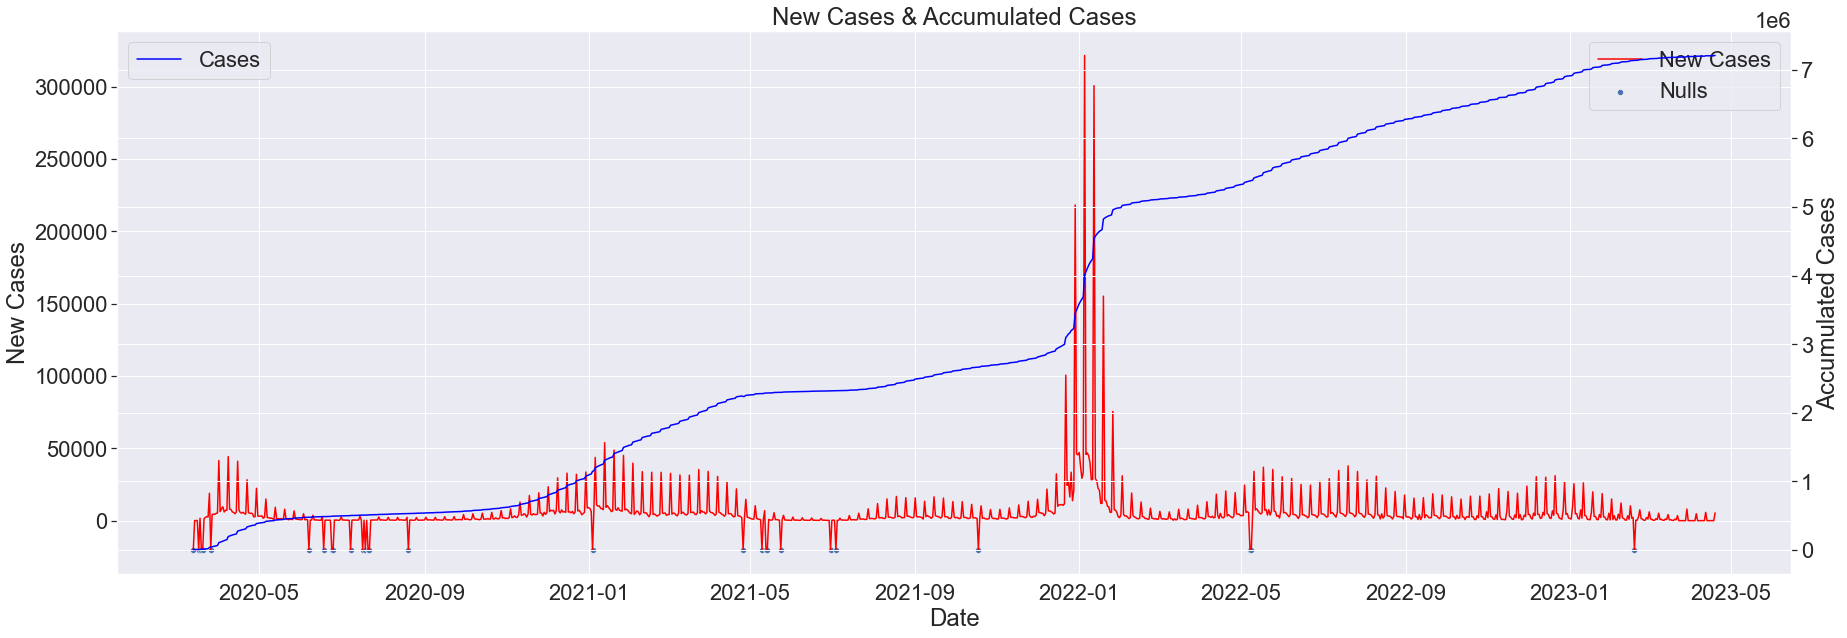

In [22]:
wiznull  = 'New Cases'
temp_newcase = np.zeros(len(NY_covid))

temp_newcase[NY_covid[wiznull].isnull()] = -20000
temp_newcase[NY_covid['New Cases'].notnull()] = NY_covid['New Cases'][NY_covid['New Cases'].notnull()]

# Fill Nulls in Cases
if list(NY_covid[NY_covid['Cases'].isnull()].index):
    NY_covid.loc[NY_covid[NY_covid['Cases'].isnull()].index, 'Cases'] = (NY_covid.loc[NY_covid[NY_covid['Cases'].isnull()].index[-1] + 1, 'Cases'] + NY_covid.loc[NY_covid[NY_covid['Cases'].isnull()].index[-1] - 1, 'Cases'])/2

# Plot New Cases with nulls.
sns.set(rc={"figure.figsize":(30, 10)}, font_scale = 2)
ax1 = sns.lineplot(x = NY_covid['Date'], y = temp_newcase, color = 'red', label = 'New Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Cases')
ax1 = sns.scatterplot(x = NY_covid['Date'][temp_newcase == -20000], y = temp_newcase[temp_newcase == -20000], sizes = 400, label = 'Nulls')
ax1.legend()
# Plot Case.
ax2 = ax1.twinx()
sns.lineplot(x = NY_covid['Date'], y = NY_covid['Cases'], color = 'blue', label = 'Cases')
ax2.set_ylabel('Accumulated Cases')
ax2.set(title = 'New Cases & Accumulated Cases')
ax2.legend()

Check if there is any difference between the sum of New Cases and the maximum of Cases. **I use this to estimate the sum of values  that should be in the places of nulls.** Comparing with the overall fluctuation of New Cases series, this is trivial, meaning these values were simply forgotten. So I just evenly assign it to the nulls in the series. 

For nulls in **Cases**, I use **New Cases**, the increment of **Cases** to estimate the value: use either the next day's Cases minus the same day's New Cases or yesterday's Cases plus today's New Cases to satisfy <u>the condition: it does not exceeds the next day's and is greater than yesterday's Cases</u>. If both cases are not allowed under <u>the condition</u>, just use the mean of two Cases next to the null. 

In [23]:
NY_covid['Cases'].max() - NY_covid['New Cases'].sum()

70633

The same treatment of empty and zero values will be applied to other cities' data. In this way, I can fill all empty values in the fields New Cases and Cases.

In [24]:
NY_covid.loc[NY_covid['New Cases'].isnull(), 'New Cases'] = (NY_covid['Cases'].max() - NY_covid['New Cases'].sum())/len(NY_covid[NY_covid[wiznull].isnull()])
NY_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1132
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1133 non-null   object
 1   Cases      1133 non-null   object
 2   New Cases  1133 non-null   object
 3   Deaths     1133 non-null   object
dtypes: object(4)
memory usage: 76.5+ KB


The field **Death** is hard to be filled by the similar extrapolation. It is also an accumulativefield, so there is an ascending trend. In this case, just fill it with polynomial interpolation. 

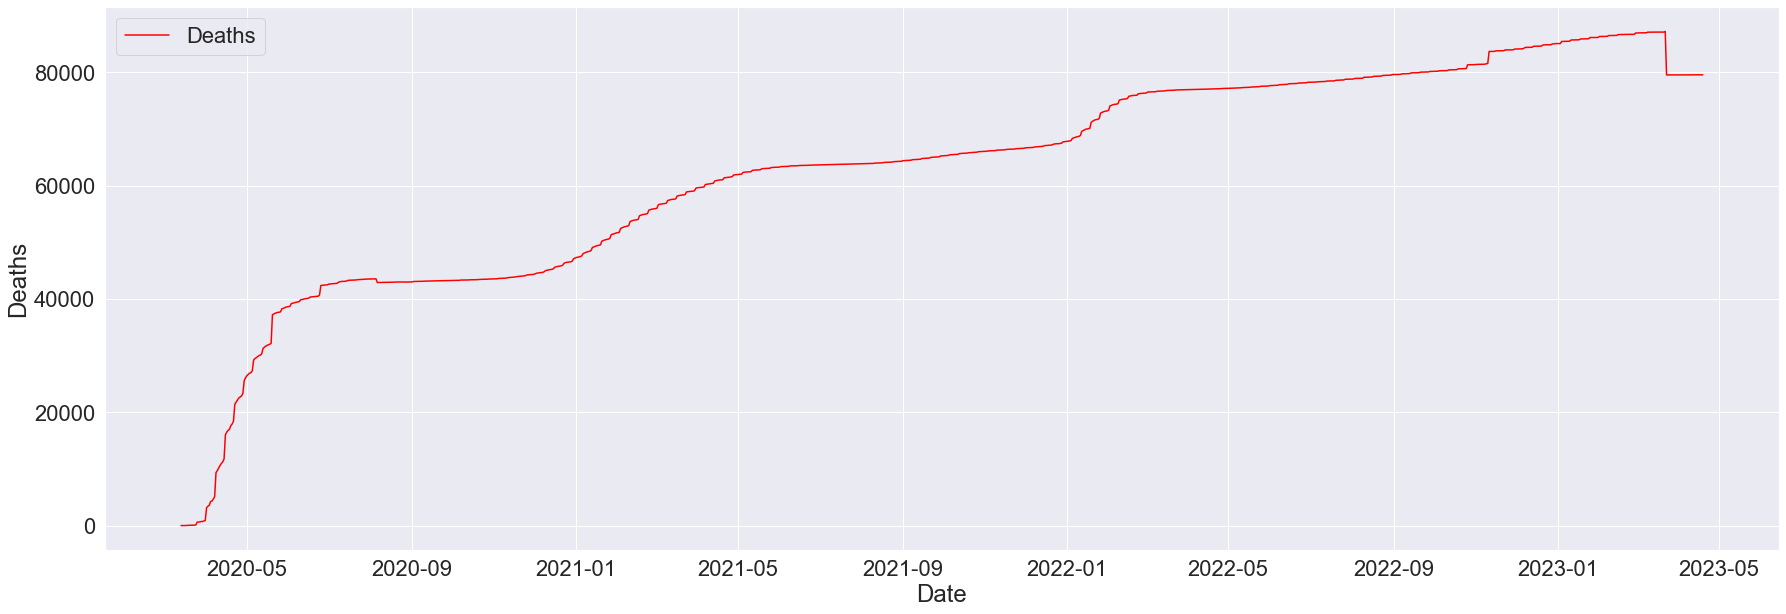

In [27]:
sns.lineplot(x = NY_covid['Date'], y = NY_covid['Deaths'], color = 'red', label = 'Deaths')

Assemble these methods into a function *fill_covid*. Also, **assuming the overall population is stable during the epidemic**, I calculate the density of infection by adding a new field **Density** which equals to **the proportion of newly infected people in the population**.

In [28]:
from scipy.interpolate import interp1d
def fill_covid(city_name):
    city_covid, city_popu = get_coviddata(city[city['City'] == city_name]['CBSAS'].values[0])
    null_idx = city_covid['New Cases'][city_covid['New Cases'].isnull()].index
    if (city_covid.isnull().sum()['New Cases'] > 0):
        city_covid.loc[null_idx, 'New Cases'] = round((city_covid['Cases'].max() - city_covid['New Cases'].sum())/len(null_idx))
    
    if (city_covid.isnull().sum()['Cases'] > 0):
        empty_idx = city_covid[(city_covid['Cases'].isnull()) | (city_covid['Cases'][city_covid['Cases'] == 0])].index
        empty_intv = [[empty_idx[0]]]
        for i in empty_idx[1:]:
            if i - 1 in empty_intv[-1]:
                empty_intv[-1].append(i)
            else: 
                empty_intv.append([i])
        city_covid.loc[city_covid['Cases'].isnull(), 'Cases'] = 0 # Prefill the nulls with 0 to facilitate the following calculation.
        for intv in empty_intv: 
            if intv[0] == 0:
                for i in intv[::-1]: # If it is empty at the very start, fill backward from the first non-null.
                    city_covid.loc[i, 'Cases'] = city_covid.loc[i + 1, 'Cases'] - city_covid.loc[i + 1, 'New Cases']
            elif intv[-1] == len(city_covid):
                for i in intv: # If it is empty at the very end, fill forward.
                    city_covid.loc[i, 'Cases'] = city_covid.loc[i - 1, 'Cases'] - city_covid.loc[i, 'New Cases']
            else:
                for i in intv: # If the interval is in the middle of the series, fill forward first.
                    city_covid.loc[i, 'Cases'] = city_covid.loc[i - 1, 'Cases'] - city_covid.loc[i, 'New Cases']
                if city_covid.loc[i, 'Cases'] > city_covid.loc[i + 1, 'Cases']:
                    # If the last filling exceeds the next day's Cases, then use the mean of two values next to the null.
                    city_covid.loc[i, 'Cases'] = round((city_covid.loc[i - 1, 'Cases'] + city_covid.loc[i + 1, 'Cases'])/2)
    if (city_covid.isnull().sum()['Deaths'] > 0):
        x = city_covid['Deaths'][(city_covid['Deaths'].notnull())].index
        y = city_covid['Deaths'][(city_covid['Deaths'].notnull())]
        x_fill = city_covid['Deaths'][(city_covid['Deaths'].isnull())].index
        f_fill = interp1d(x, y, kind='cubic', fill_value = 'extrapolate')
        city_covid.loc[x_fill, 'Deaths'] = f_fill(x_fill)
    city_covid['Density'] = city_covid['New Cases']/city_popu
    return  city_covid, city_covid.isnull().sum()

In [29]:
LA_covid, LA_null = fill_covid('Los Angeles')

Remained Nulls in LA Data
Date         0
Cases        0
New Cases    0
Deaths       0
Density      0
dtype: int64


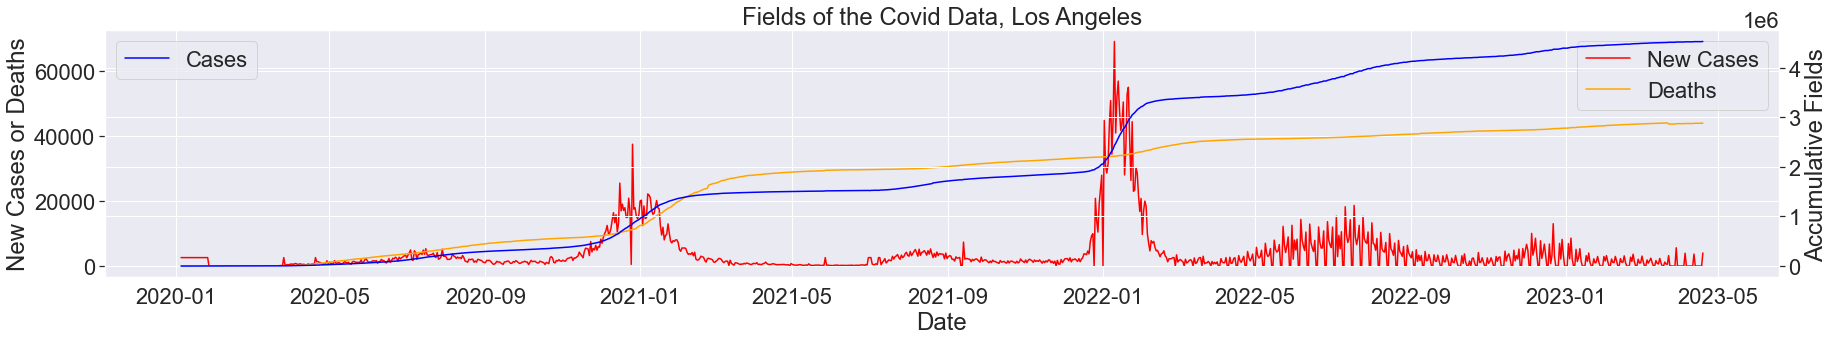

In [30]:
# Plot New Cases with nulls.
#LA_covid, LA_popu = get_coviddata(city[city['City'] == 'Los Angeles']['CBSAS'].values[0])
plt.subplot(211)
sns.set(rc={"figure.figsize":(30, 10)}, font_scale = 2)
ax1 = sns.lineplot(x = LA_covid['Date'], y = LA_covid['New Cases'], color = 'red', label = 'New Cases')
ax1 = sns.lineplot(x = LA_covid['Date'], y = LA_covid['Deaths'], color = 'orange', label = 'Deaths')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Cases or Deaths')
ax1.legend()
# Plot Case.
ax2 = ax1.twinx()
sns.lineplot(x = LA_covid['Date'], y = LA_covid['Cases'], color = 'blue', label = 'Cases')

ax2.set_ylabel('Accumulative Fields')
ax2.set(title = 'Fields of the Covid Data, Los Angeles')
ax2.legend()
print('Remained Nulls in LA Data')
print(LA_null)

So far, I can fill all nulls in any covid datasets by calling the function *fill_covid*.

# Data Visualization

This section uses visualization modules to explore datasets and prepare for possible analysis.

## Main Cities in US

With two spatial data manipulation modules, **Geopandas and shapely.geometry**, I create point features of cities from their coordinates and plot them in a map . Also, add a basemap from the website of US Census Bureau.

In [31]:
city['Coordinates'] = list(zip(city.Longitude, city.Latitude))
city['Coordinates'] = city['Coordinates'].apply(Point)
City = gp.GeoDataFrame(city, geometry='Coordinates')
City = City[City['CBSAS'].notnull()]
City = City.drop(index = City[City['City'] == 'Manhattan'].index)
City

,City,Latitude,Longitude,CBSAS,Coordinates
0,New York,40.71427,-74.00597,35620,POINT (-74.00597 40.71427)
1,Los Angeles,34.05223,-118.24368,31080,POINT (-118.24368 34.05223)
2,Chicago,41.85003,-87.65005,16980,POINT (-87.65005 41.85003)
3,Houston,29.76328,-95.36327,26420,POINT (-95.36327 29.76328)
4,Philadelphia,39.95233,-75.16379,35420,POINT (-75.16379 39.95233)
5,Phoenix,33.44838,-112.07404,38060,POINT (-112.07404 33.44838)
6,San Antonio,29.42412,-98.49363,41700,POINT (-98.49363 29.42412)
7,San Diego,32.71571,-117.16472,41740,POINT (-117.16472 32.71571)
8,Dallas,32.78306,-96.80667,19100,POINT (-96.80667 32.78306)
11,San Jose,37.33939,-121.89496,41940,POINT (-121.89496 37.33939)


Text(0.5, 1.0, 'Main Cities')

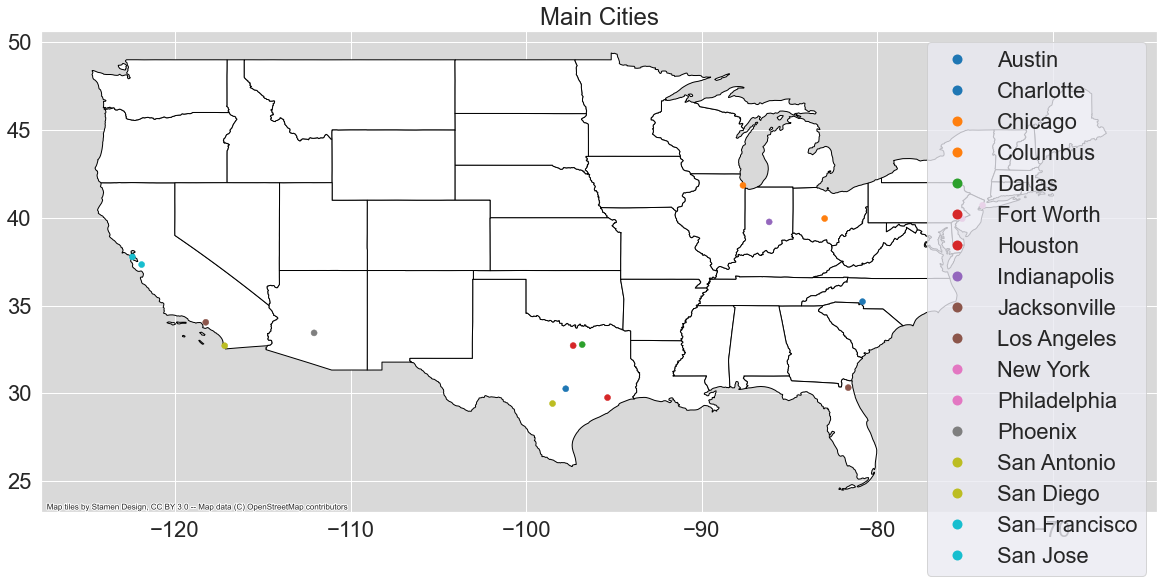

In [32]:
states = 'https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip'
places = gp.read_file(states)

# Define a function to select the location of the map view.
xmax = places.geometry.bounds.maxx
xmin = places.geometry.bounds.minx
ymax = places.geometry.bounds.maxy
ymin = places.geometry.bounds.miny
state_scale = places[(xmax < -60) & (xmin > -150) & (ymax < 50) & (ymin > 20)]

fig, ax = plt.subplots(figsize = (20, 10), subplot_kw = {'aspect':'equal'})
City.set_crs(epsg = 3857)
state_scale.to_crs(epsg = 3857)
state_scale.plot(ax = ax, COLOR = 'white', edgecolor = 'black')
City.plot(ax = ax, column = 'City', linewidth=0.5, legend = True)
ctx.add_basemap(ax = ax, zoom = 12, source = ctx.providers.Stamen.TonerLite)
ax.set_title('Main Cities')

Each point of city is given a unique color.

## Covid19 Data

For each city, plot a line for the density of infection to present the trend of Covid19. Also, choose their maximum of infection density as the graduated symbology for points of cities to point them in the map. 

Basically, infections in major cities across the US show similar temporal patterns, meaning their infected population changed almost simultaneously. LA and NYC has the densest infection due to their largest population.

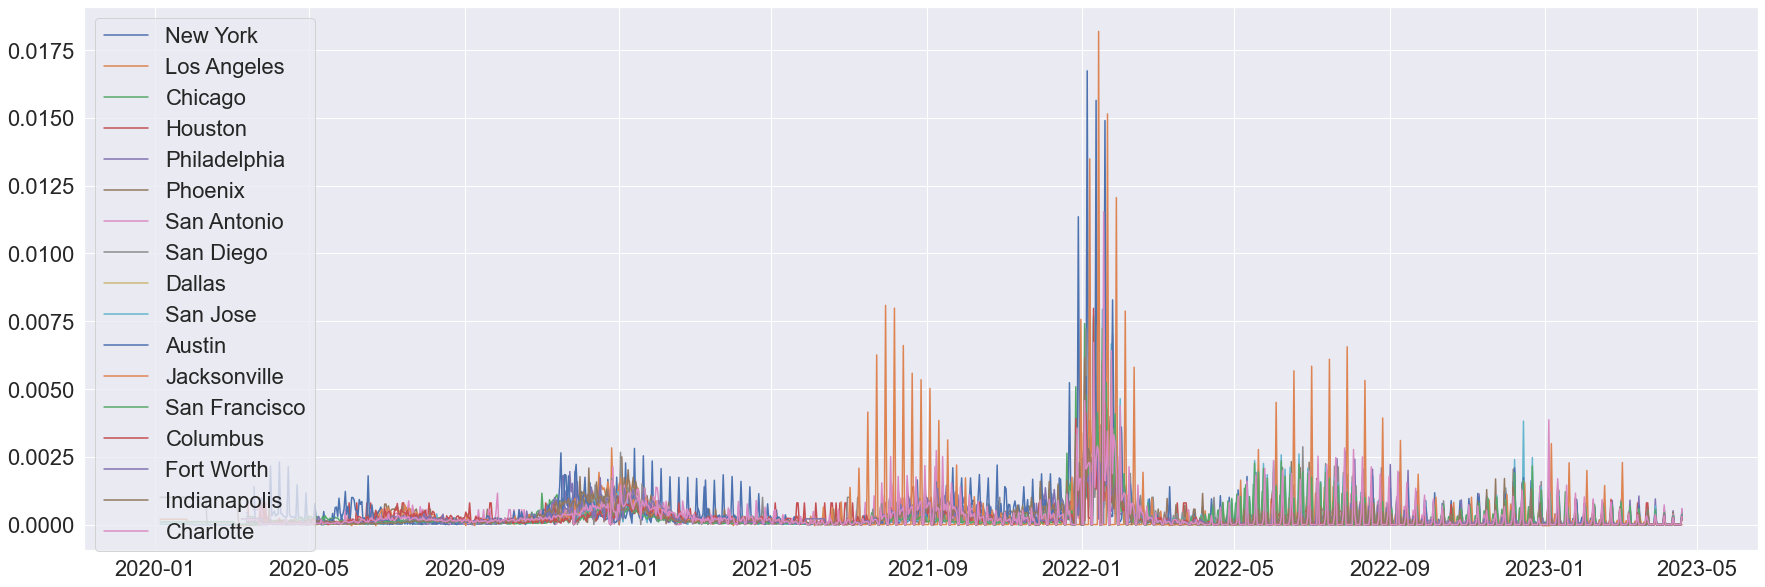

In [36]:
# Plot 1, Trend of Covid19.
for c in City['City']:
    ct_covid, ct_null = fill_covid(c)
    City.loc[City['City'] == c, 'Max Density'] = ct_covid['Density'].max()
    plt.plot(ct_covid['Date'], ct_covid['Density'], label = c)
plt.legend()

Density of Infection.

Text(0.5, 1.0, 'Maximum Infection Density')

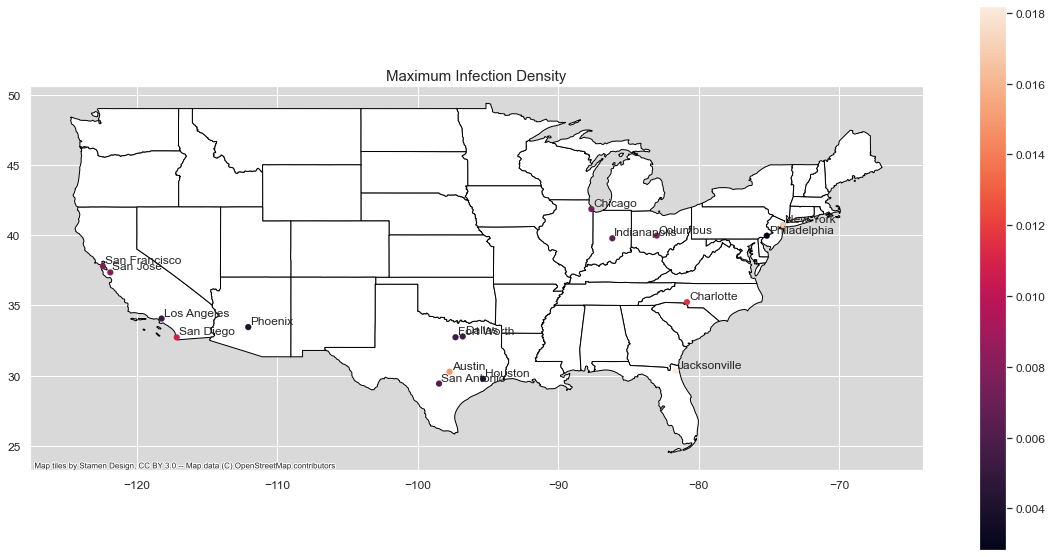

In [37]:
fig, ax = plt.subplots(figsize = (20, 10), subplot_kw = {'aspect':'equal'})
state_scale.plot(ax = ax, color = 'white', edgecolor = 'black')
City.plot(ax = ax, column = 'Max Density', linewidth = 0.2, legend = True)
ctx.add_basemap(ax = ax, zoom = 5, source = ctx.providers.Stamen.TonerLite)
for x, y, label in zip(City.geometry.x, City.geometry.y, City.City):
    ax.annotate(label, xy = (x, y), xytext = (2, 3), textcoords = "offset points", fontsize = 12)
ax.figure.axes[1].tick_params(labelsize = 12)
ax.figure.axes[0].tick_params(labelsize = 12)

ax.set_title('Maximum Infection Density', fontsize = 15)

Austin and New York have the largest density thus are most greatly affected by Covid19.

## Airbnb Listings

In [38]:
Anblist = raw_listing.copy()
Review = raw_review.copy()
Anblist.columns

Index(['listing_id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'district', 'city', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable'],
      dtype='object')

### Distribution of the Year Start Hosting

Text(0.5, 1.0, 'Distribution of Years Host Starts')

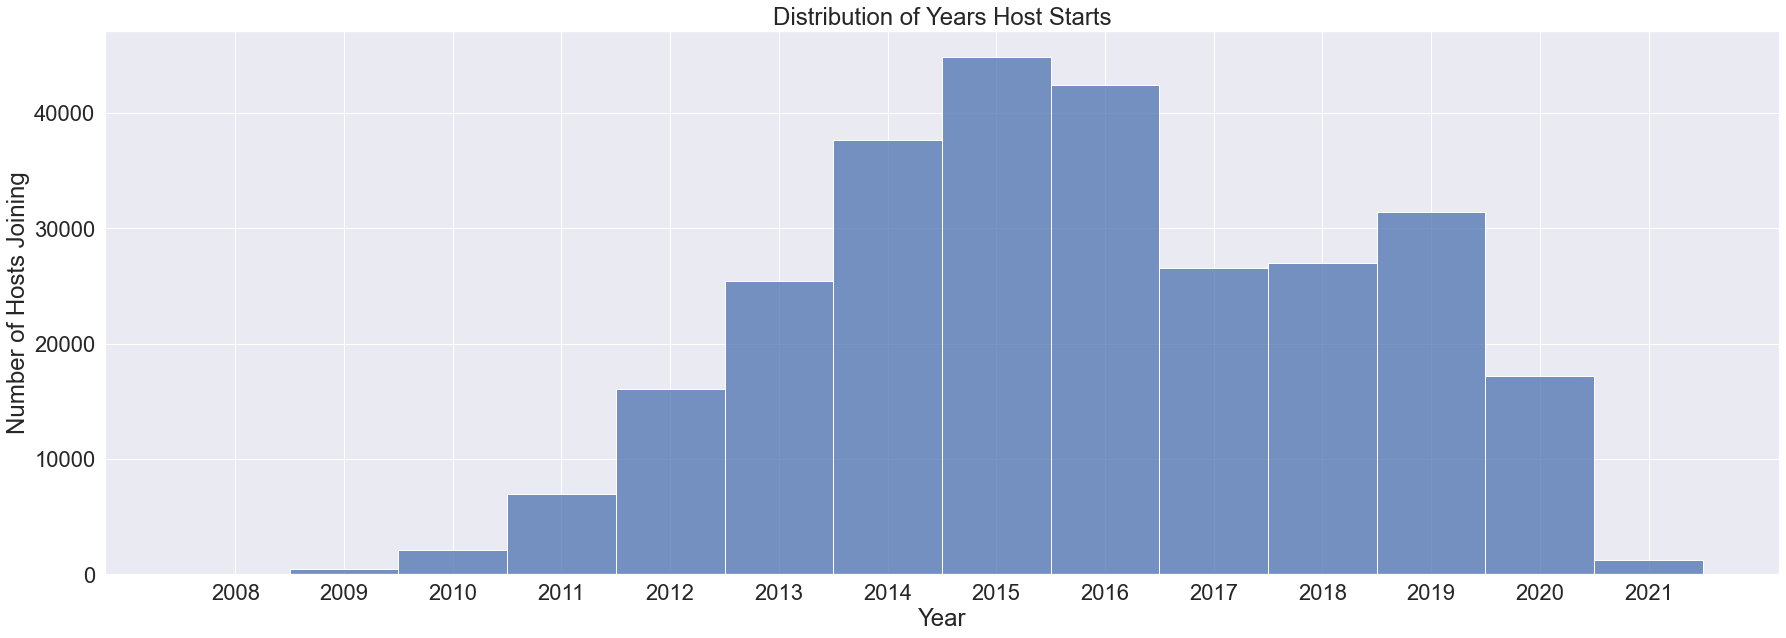

In [39]:
hist_hstsnc = sns.histplot(Anblist['host_since'].dropna().sort_values().map(lambda d: d[: 4]))
hist_hstsnc.set_xlabel('Year')
hist_hstsnc.set_ylabel('Number of Hosts Joining')
hist_hstsnc.set_title('Distribution of Years Host Starts')

From 2008 to 2015, Airbnb expanded quickly as every year there were more people joined in than the last year. More hosts joined Airbnb during 2014 to 2016. In 2020, much fewer started their businesses compared with 2019.

### Superhosts and Hosts in All Room Types

There are totally four types of rooms. Then I use a nested pie plot to show proportion of super and normal hosts in each type. The outer layer has percentages of all the four room types and the inner has the percentages of super and normal hosts from each type.

In [40]:
rtypes = Anblist['room_type'].value_counts()
print(rtypes)
p_type = {}
for tp, tab in Anblist[['room_type', 'host_is_superhost']].groupby(by = 'room_type'):
    p_type[tp.format(len(tab)/len(Anblist[['room_type']]))] = len(tab)/len(Anblist[['room_type']])
p_hst = {}
for tab in Anblist[['room_type', 'host_is_superhost', 'name']].groupby(by = ['room_type', 'host_is_superhost']):
    if tab[0][1] == 't':
        p_hst[tab[0][0] + ' Superhost'.format(len(tab[1])/len(Anblist['room_type']))] = len(tab[1])/len(Anblist['room_type'])
    elif tab[0][1] == 'f':
        p_hst[tab[0][0].format(len(tab[1])/len(Anblist['room_type']))] = len(tab[1])/len(Anblist['room_type'])

Entire place    182005
Private room     86988
Hotel room        5857
Shared room       4862
Name: room_type, dtype: int64


In [41]:
p_type.values()

dict_values([0.6506871353392061, 0.02093939480608626, 0.31099130534263814, 0.01738216451206956])

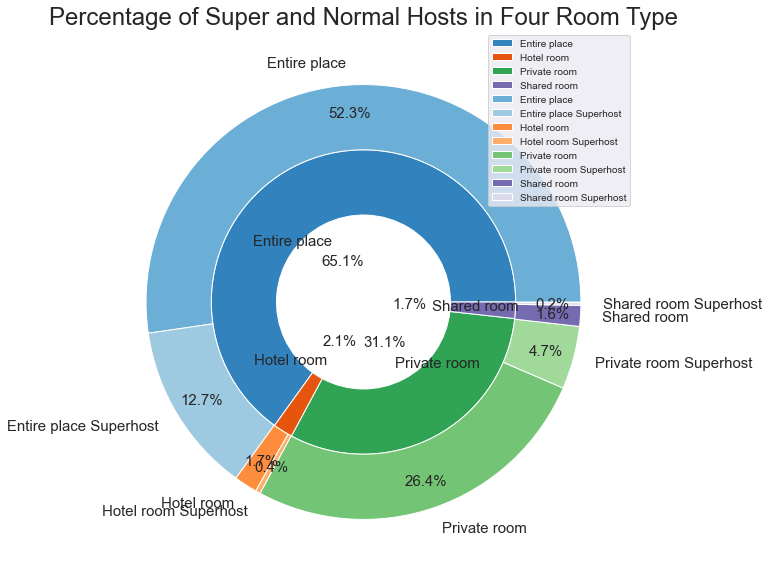

In [42]:
fig, ax = plt.subplots()

size = 0.3

cmap = matplotlib.cm.tab20c
inner_colors = cmap(np.arange(len(p_type.values()))*4)
outer_colors = cmap([1, 2, 5, 6, 9, 10, 12, 15])
to_pcnt = lambda p: '{:.2%}'.format(p)
patches1, l_text1, p_text1  = ax.pie(p_type.values(), radius = 1 - size, colors = inner_colors,
       wedgeprops = dict(width = size, edgecolor = 'w'), labels = p_type.keys(), labeldistance = .45, pctdistance = .3, autopct = "%1.1f%%")

patches2, l_text2, p_text2 = ax.pie(p_hst.values(), radius = 1, colors = outer_colors,
       wedgeprops=dict(width= size, edgecolor = 'w'), labels = p_hst.keys(), labeldistance = 1.1, pctdistance = .87, autopct = "%1.1f%%")
l_text, p_text = ax.set(aspect = 'equal', title = 'Percentage of Super and Normal Hosts in Four Room Type')

for txt in [p_text1, l_text1, p_text2, l_text2]:
    for t in txt:
        t.set_size(15)
ttl_txt = plt.legend(fontsize = 10, loc = 'upper right')
plt.show()

Superhosts are the minority among any type of room provider. Most hosts provide entire places or private rooms.

# Analysis

## Pupularity of Superhosts

Is it easier for superhosts to get more customers (have more listings)? Define a 'popular host' if it has a **'host_total_listings_count'** more than 50, otherwise it is 'normal'. Run a chi-square test.

In [43]:
from scipy.stats import chi2_contingency
pop_ns_hosts = Anblist[(Anblist['host_total_listings_count'] > 50) & (Anblist['host_is_superhost'] == 'f')]\
['host_total_listings_count']
pop_s_hosts = Anblist[(Anblist['host_total_listings_count'] > 50) & (Anblist['host_is_superhost'] == 't')]\
['host_total_listings_count']

norm_ns_hosts = Anblist[(Anblist['host_total_listings_count'] <= 50) & (Anblist['host_is_superhost'] == 'f')]\
['host_total_listings_count']
norm_s_hosts = Anblist[(Anblist['host_total_listings_count'] <= 50) & (Anblist['host_is_superhost'] == 't')]\
['host_total_listings_count']

infom = np.array([[len(pop_ns_hosts), len(norm_ns_hosts)], [len(pop_s_hosts), len(norm_s_hosts)]])
res = chi2_contingency(infom)
print('p value of the test is ', res[1])

p value of the test is  2.360233090147678e-105


$p$ is far less than 0.05 so superhosts are more likely to have more customers.

## Time Series Pattern Mining: Cycle of Housing Prices

By merging the listing with reviews, I can get a time series table, which time stamps are the dates housings in listings were rated. I thus plan to see the locations of housings and times listings were made. I will first select a city and then in a time range spanning several years, I set month as the granularity, calculate the monthly mean price of listings and the volume of orders. Then I will use autocorrelation function to check if each series is autocorrelated thus has seasonality; if it has seasonality, I will try to describe the pattern of it. If both of them are periodic, then I try to find the correlation between them and build a quantitative model.

To ensure that every listing and price has a time stamp, I review left join listing data. Making sure there is no empth values.

In [44]:
rv = Anblist[['listing_id', 'city', 'price']].copy();
ts = Review[['listing_id', 'date']].copy();
price_time = pd.merge(ts, rv, how = 'left')

In [45]:
price_time.isnull().sum()

listing_id    0
date          0
city          0
price         0
dtype: int64

In [46]:
spa = Anblist[['listing_id', 'latitude', 'longitude', 'property_type', 'room_type', 'city', 'price']][raw_listing['city'] == 'New York'].copy();
temp = Review[['listing_id', 'date']].copy();
st_data = pd.merge(spa, temp, on = 'listing_id', how = 'left')
st_data.to_csv('spatio_temporal_abnb.csv')

Next, find a city.

In [47]:
price_time['city'].unique()

array(['Paris', 'New York', 'Bangkok', 'Hong Kong', 'Mexico City',
       'Cape Town', 'Rio de Janeiro', 'Sydney', 'Istanbul', 'Rome'],
      dtype=object)

In [48]:
def price_a_city(df, city):
    
    def get_month_year(date):
        return date[: -3]
    
    # Constructing the Month-Year table for a city.
    city_price = df[df['city'] == city][['city', 'date', 'price']].copy()
    city_price['Month_Year'] = city_price['date'].map(get_month_year)

    # The table of monthly average price and order volume.
    avgpn_city = pd.DataFrame(columns = ['Month_Year', 'Avg_Price', 'n_Order'])
    avgp_ = []
    avgn_ = []
    for i in city_price['Month_Year'].unique():
        avgp_.append(city_price[city_price['Month_Year'] == i]['price'].mean())
        avgn_.append(sum(city_price[city_price['Month_Year'] == i]['price']))

    avgpn_city['Month_Year'] = city_price['Month_Year'].unique();
    avgpn_city['Avg_Price'] = avgp_
    avgpn_city['n_Order'] = avgn_
    avgpn_city = avgpn_city.sort_values('Month_Year').reset_index()
    
    return city_price, avgpn_city # Return the two tables.

def vis_p_n(city, avgpn_city):
    t_ = np.arange(0, len(avgpn_city), 1)

    sns.set(rc={"figure.figsize":(16, 8)})

    ax1 = sns.lineplot(t_, avgpn_city['Avg_Price'], color='blue')
    ax1.set_ylabel('Monthly Average Prices')
    ax1.set_ylim(avgpn_city['Avg_Price'].min(), max(avgpn_city['Avg_Price']))
    ax1.legend(['Monthly Average Prices, {}'.format(city)], loc="upper left")

    ax2 = ax1.twinx()

    ax2 = sns.lineplot(t_, avgpn_city['n_Order'], color='orange')
    ax2.set_ylabel('Monthly Order Volume')
    ax2.set_ylim(min(avgpn_city['n_Order']), max(avgpn_city['n_Order']))
    ax2.set_xlabel('Time/Days')
    ax2.legend(['Monthly Order Volume, {}'.format(city)], loc="upper right")

First I will try New York housing prices. I built a new column 'Year_Month' facilitating calculation.

In [49]:
NY_price = price_time[price_time['city'] == 'New York'][['city', 'date', 'price']]

In [50]:
def get_month_year(date):
    return date[: -3]

NY_price['Month_Year'] = NY_price['date'].map(get_month_year)
NY_price

,city,date,price,Month_Year
1049370,New York,2019-12-01,74,2019-12
1049371,New York,2019-12-01,89,2019-12
1049372,New York,2019-12-01,85,2019-12
1049373,New York,2019-12-01,135,2019-12
1049374,New York,2019-12-01,250,2019-12
...,...,...,...,...
2065521,New York,2021-02-05,110,2021-02
2065522,New York,2021-01-30,46,2021-01
2065523,New York,2021-02-04,65,2021-02
2065524,New York,2021-01-31,30,2021-01


Then I simply calculate the monthly mean of prices and corresponding counts of orders.

In [51]:
avgp_NY = pd.DataFrame(columns = ['Month_Year', 'Avg_Price'])
avgp_ny = []
avgn_ny = []
for i in NY_price['Month_Year'].unique():
    avgp_ny.append(NY_price[NY_price['Month_Year'] == i]['price'].mean())
    avgn_ny.append(sum(NY_price[NY_price['Month_Year'] == i]['price']))

avgp_NY['Month_Year'] = NY_price['Month_Year'].unique();
avgp_NY['Avg_Price'] = avgp_ny
avgp_NY['n_Order'] = avgn_ny
avgp_NY = avgp_NY.sort_values('Month_Year').reset_index()
avgp_NY

,index,Month_Year,Avg_Price,n_Order
0,141,2009-04,83.000000,83
1,84,2009-05,86.500000,519
2,108,2009-06,95.000000,380
3,85,2009-07,92.625000,741
4,109,2009-08,183.428571,1284
...,...,...,...,...
138,15,2020-10,116.701857,1212649
139,25,2020-11,115.747641,1177385
140,27,2020-12,113.548595,1054980
141,24,2021-01,113.215798,1096495


To check the overall tendency of monthly average prices in NY and refer to the volume of orders at the same time, I use the dual axis plot.

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


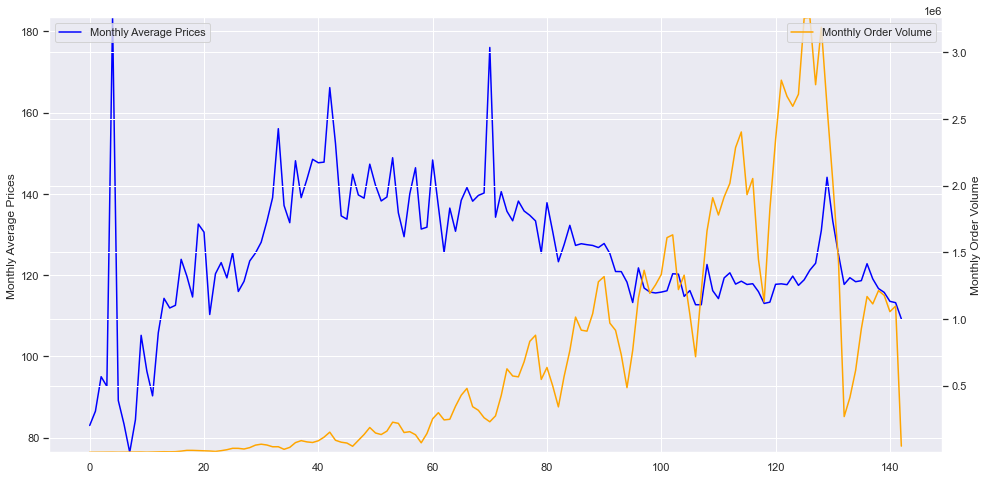

In [52]:
t_NY = np.arange(0, len(avgp_NY), 1)

sns.set(rc={"figure.figsize":(16, 8)})

ax1 = sns.lineplot(t_NY, avgp_NY['Avg_Price'], color='blue')
ax1.set_ylabel('Monthly Average Prices')
ax1.set_ylim(avgp_NY['Avg_Price'].min(), max(avgp_NY['Avg_Price']))
ax1.legend(['Monthly Average Prices'], loc="upper left")

ax2 = ax1.twinx()

ax2 = sns.lineplot(t_NY, avgp_NY['n_Order'], color='orange')
ax2.set_ylabel('Monthly Order Volume')
ax2.set_ylim(min(avgp_NY['n_Order']), max(avgp_NY['n_Order']))
ax2.set_xlabel('Time/Days')
ax2.legend(['Monthly Order Volume'], loc="upper right")

It is clear that, the monthly order volume has a significant seasonality and a increasing tendency; the sharp decrese of order volume in the back is likely due to the epidemic in 2020. But the series of the monthly order volue has a stable one-year's cycle.  
Then plot the autocorrelation function of monthly prices after normalization to see if there is seasonality.

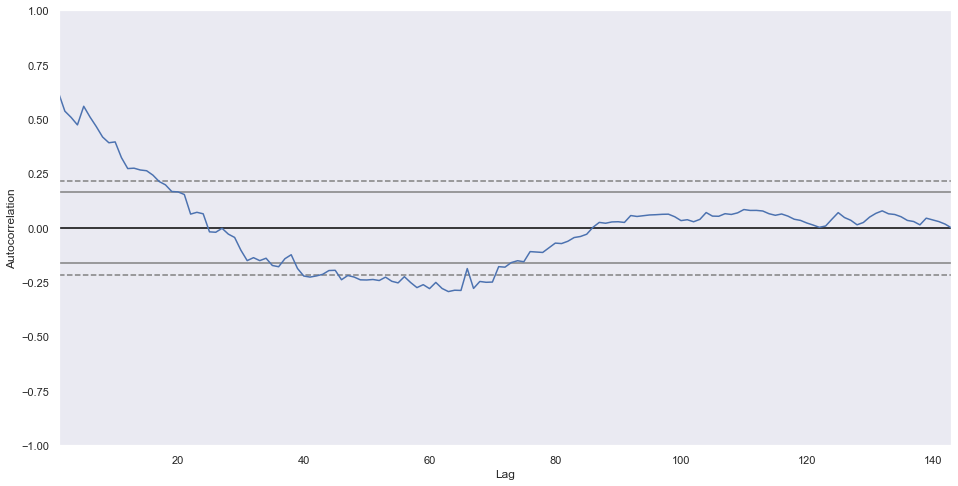

In [53]:
pd.plotting.autocorrelation_plot(normalize(avgp_NY[['Avg_Price']], axis = 0))

As it shows, the monthly mean price series is not stationary as it does not truncate fast.  
But the ACF cannot interpret its specific fluctuations, like the main and subordinate cycles in potential seasonal fluctuation.So I decide to use wavelet transformation to ① denoise the monthly mean price series and ② use the denoised series to find the largest cycle and the finest.  
Furthermore, I will try to detect their causality and build a quantitative model to show this. Hopefully, the monthly order volume could be a predictor of the prices.

In [54]:
import pywt

First, normalize the monthly average price data (min-max) and try denoising it at **signal level (one level)** with db wavelets. When denoising, remove the low frequency part to eliminate the temporal trend of the series.

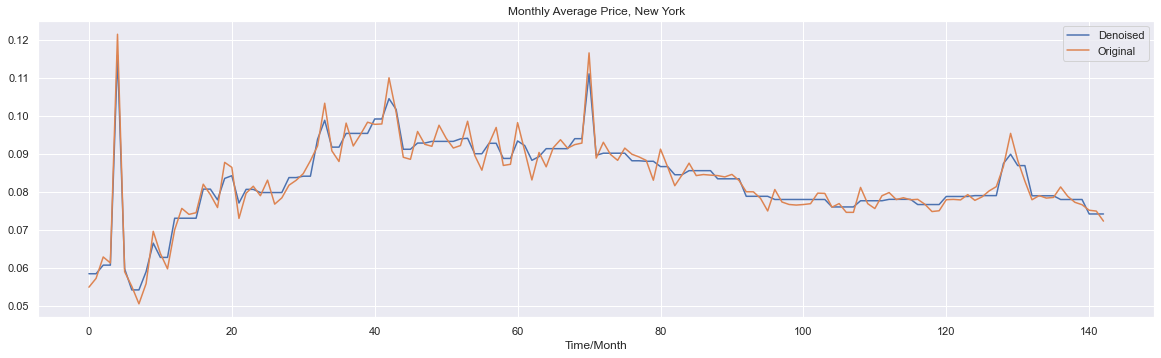

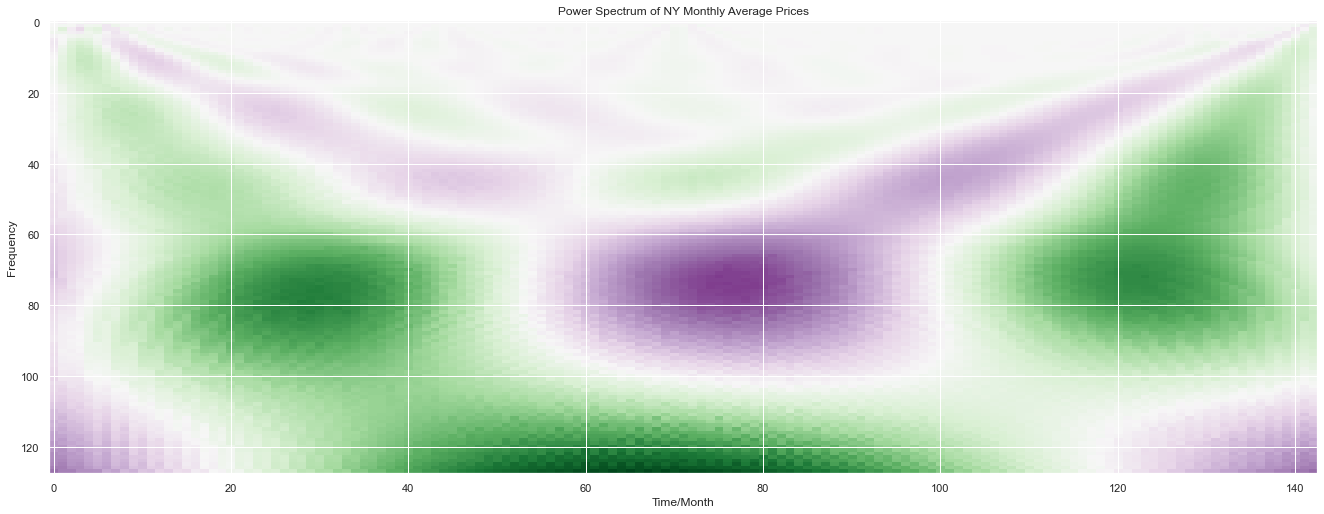

In [55]:
'''With Temporal Trend'''
plt.figure(figsize = (20, 12))
# Denoising
avgp_ny_ = normalize(np.array(avgp_NY['Avg_Price']).reshape(1, -1))[0]
coef = pywt.wavedec(avgp_ny_, 'db1', level = 3)
for i in range(1, len(coef)):
    coef[i] = pywt.threshold(coef[i], .1 * max(coef[i]))
dno_avgp_ny_wizt = pywt.waverec(coef[:], 'db1')
dno_avgp_ny_wizt = dno_avgp_ny_wizt[: -1]
plt.subplot(211)
plt.plot(np.arange(0, len(dno_avgp_ny_wizt)), dno_avgp_ny_wizt)
plt.plot(np.arange(0, len(avgp_ny_)), avgp_ny_)
plt.title('Monthly Average Price, New York')
plt.xlabel('Time/Month');
plt.legend(['Denoised', 'Original'])
plt.show()

# Continuous Wavelet Decomposition
coefs_ctn_wizt, f = pywt.cwt(dno_avgp_ny_wizt, np.arange(1, 129, 1), 'morl')
plt.figure(figsize = (50, 20))
plt.subplot(221)
plt.imshow(coefs_ctn_wizt, cmap = 'PRGn', aspect = 'auto',
           vmax = abs(coefs_ctn_wizt).max(), vmin = -abs(coefs_ctn_wizt).max())
plt.ylabel('Frequency');
plt.xlabel('Time/Month');
plt.title('Power Spectrum of NY Monthly Average Prices')

plt.subplots_adjust(hspace = 0.4)

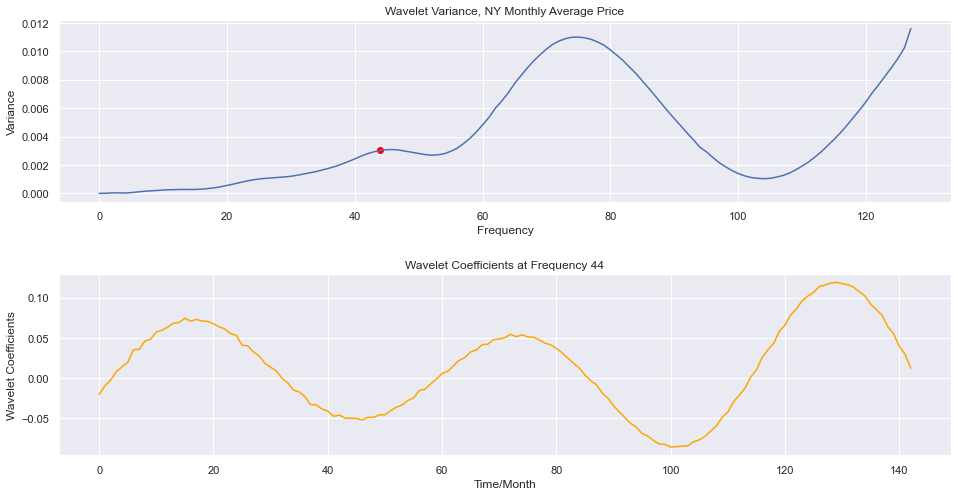

In [56]:
plt.subplot(211)
plt.plot(np.arange(0, len(coefs_ctn_wizt), 1), np.var(coefs_ctn_wizt, axis = 1))
freq = 44
plt.xlabel('Frequency'); plt.ylabel('Variance')
plt.scatter(freq, np.var(coefs_ctn_wizt[int(freq)]), c = 'red')
plt.title('Wavelet Variance, NY Monthly Average Price')

plt.subplot(212)
plt.plot(np.arange(0, len(dno_avgp_ny_wizt), 1), coefs_ctn_wizt[int(freq)], c = 'orange')
plt.title('Wavelet Coefficients at Frequency {}'.format(freq))
plt.xlabel('Time/Month'); plt.ylabel('Wavelet Coefficients')

plt.subplots_adjust(hspace = 0.4)

With the variance plot, we can see the market cycle of roughly 40 months (44).

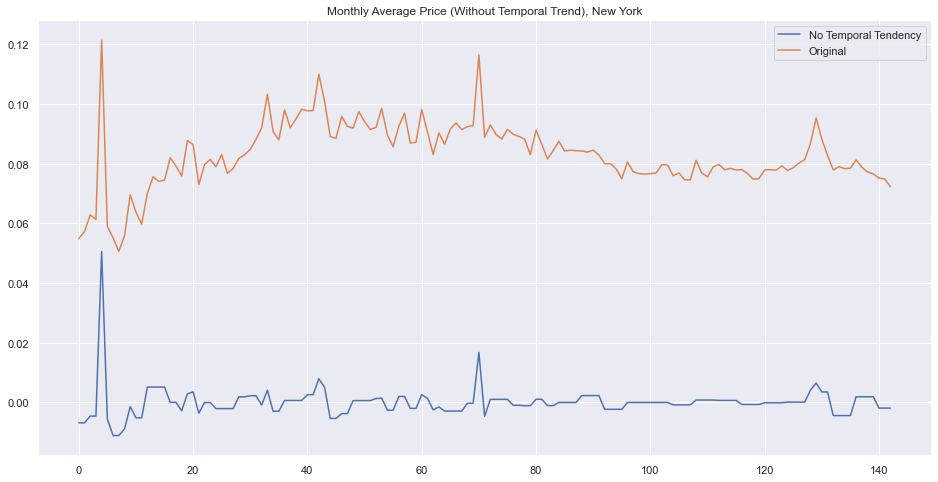

In [57]:
'''Without Temporal Tendency'''
avgp_ny_ = normalize(np.array(avgp_NY['Avg_Price']).reshape(1, -1))[0]
coef = pywt.wavedec(avgp_ny_, 'db1', level = 3)
for i in range(1, len(coef)):
    coef[i] = pywt.threshold(coef[i], .1 * max(coef[i]))
coef[0] = coef[0] - coef[0] # Eliminating the Temporal Tendency
dno_avgp_ny = pywt.waverec(coef[:], 'db1')
dno_avgp_ny = dno_avgp_ny[: -1]
plt.plot(np.arange(0, len(dno_avgp_ny)), dno_avgp_ny)
plt.plot(np.arange(0, len(avgp_ny_)), avgp_ny_)
plt.title('Monthly Average Price (Without Temporal Trend), New York')
plt.legend(['No Temporal Tendency', 'Original'])

We assume the sampling period is 1 (a special unit here is trivial), then choose Morlet wavelet for continuous decomposition. To visualize the result, plot the global power spectrum.

Text(0.5, 1.0, 'Power Spectrum of NY Monthly Average Prices (No Temporal Trend)')

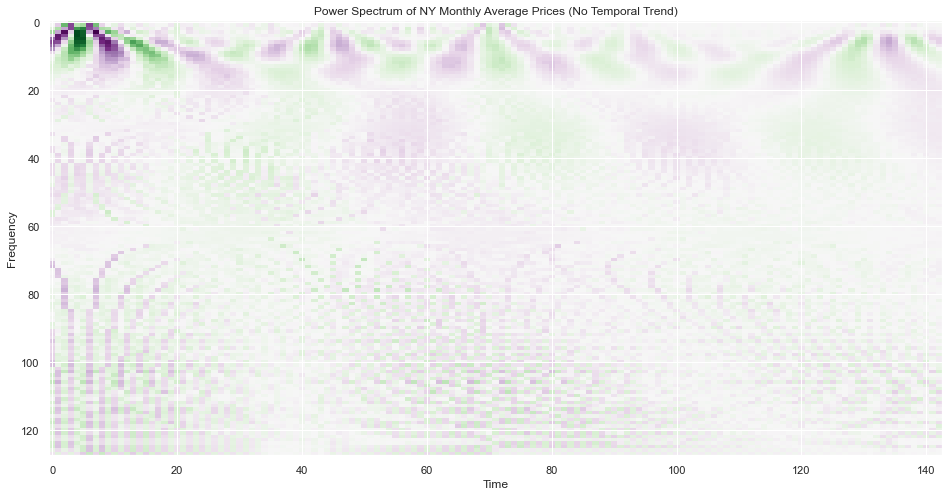

In [58]:
coefs_ctn, f = pywt.cwt(dno_avgp_ny, np.arange(1, 129, 1), 'morl')
plt.imshow(coefs_ctn, cmap = 'PRGn', aspect = 'auto',
           vmax = abs(coefs_ctn).max(), vmin = -abs(coefs_ctn).max())
plt.ylabel('Frequency');
plt.xlabel('Time');
plt.title('Power Spectrum of NY Monthly Average Prices (No Temporal Trend)')

If we search for a main and a finest cycle on purpose, we may see a roughly 4 years' when frequency is 50 Hertz and a 6 month's cycle when frequency is 10 Hertz. The latter is mych less significant (lighter color) as it does not have a significant fluctuation globally as the main cycles do, however this does not mean such cycle does not exist. As long as at this frequency, it has a more significant fluctuation than the ambient frequencies do, we can say there is a locally significant cycle.  
To show this clearer, I remove the temporal tendency and use variance of continuous wavelet coefficients to see the local maximum of fluctuation in the frequency region.    

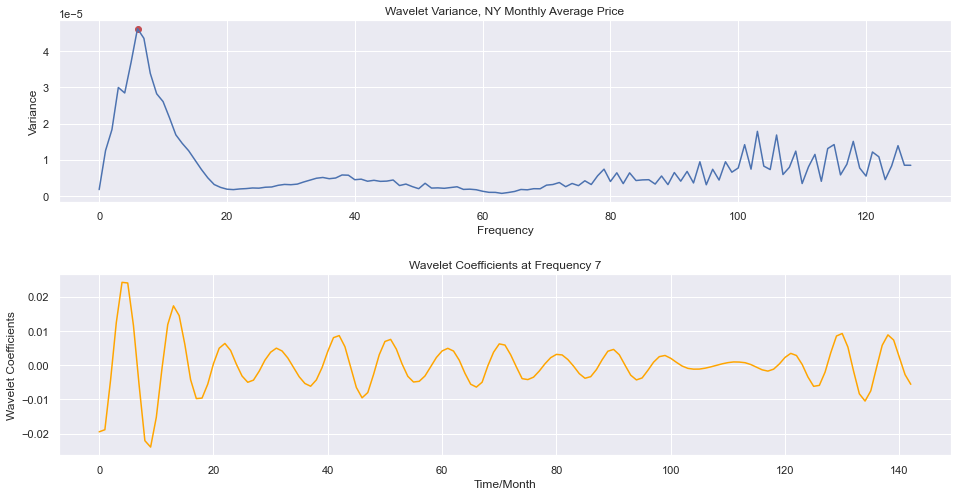

In [59]:
plt.subplot(211)
plt.plot(np.arange(0, len(coefs_ctn), 1), np.var(coefs_ctn, axis = 1))
plt.xlabel('Frequency'); plt.ylabel('Variance')
plt.title('Wavelet Variance, NY Monthly Average Price')
freq = None
for i in range(len(np.var(coefs_ctn, axis = 1))):
    if np.var(coefs_ctn, axis = 1)[i] == max(np.var(coefs_ctn, axis = 1)):
        freq = i
plt.scatter(freq, np.var(coefs_ctn[int(freq)]), c = 'r')

plt.subplot(212)
plt.plot(np.arange(0, len(dno_avgp_ny), 1), coefs_ctn[int(freq)], c = 'orange')
plt.title('Wavelet Coefficients at Frequency {}'.format(freq + 1))
plt.xlabel('Time/Month'); plt.ylabel('Wavelet Coefficients')

plt.subplots_adjust(hspace = 0.4)

After removing temporal tendency, it is noticeable that the former frequencies where the cycles of the series were global significant are now no longer significant, while it was insignificant before but now significant after when frequency equals 10 or so: we see there is a local maximum of coefficient variance when frequency equals 7, so we can say there is a seven-months' cycle int the price fluctuation. In fact, we can regard it as a half year's cycle.

Then I want to use Granger Causality Test to see if there is causality between monthly average price and order volume. The null hypothesis is 'Granger non causality'. Before testing, I make sure the series stationary by Augmented Dickey-fuller Test.

In [60]:
from statsmodels.tsa.stattools import adfuller
print('\033[1mAugmented Dickey-fuller Test for Denoised NYC Monthly Order Volume\033[0m')
dftest = adfuller(dno_avgp_ny, autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Augmented Dickey-fuller Test for Denoised NYC Monthly Order Volume
Test Statistic                -7.965792e+00
p-value                        2.867456e-12
#lags used                     5.000000e+00
number of observations used    1.370000e+02
critical value (1%)           -3.479007e+00
critical value (5%)           -2.882878e+00
critical value (10%)          -2.578149e+00
dtype: float64


F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


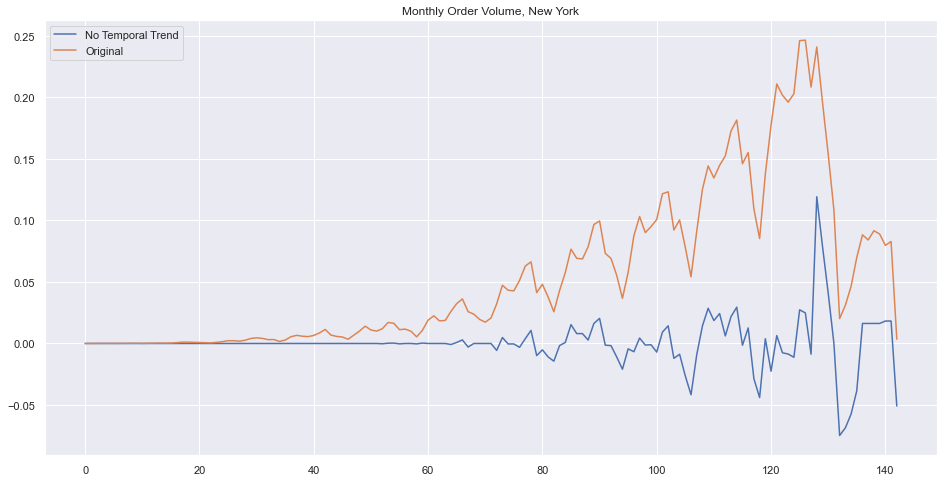

In [61]:
avgn_ny_ = normalize(np.array(avgp_NY['n_Order']).reshape(1, -1))[0]
coef_n = pywt.wavedec(avgn_ny_, 'db1', level = 3)
for i in range(1, len(coef_n)):   
    coef_n[i] = pywt.threshold(coef_n[i], .1 * max(coef_n[i]))
coef_n[0] = coef_n[0] - coef_n[0]
dno_avgn_ny = pywt.waverec(coef_n[:], 'db1') # To eliminate the temporal temdency, remove the low frequency part when filter the signal
dno_avgn_ny = dno_avgn_ny[: -1]
plt.plot(np.arange(0, len(dno_avgn_ny)), dno_avgn_ny)
plt.plot(np.arange(0, len(avgn_ny_)), avgn_ny_)
plt.title('Monthly Order Volume, New York')
plt.legend(['No Temporal Trend', 'Original'])

In [62]:
print('\033[1mAugmented Dickey-fuller Test for Denoised NYC Monthly Housing Price\033[0m')
dftest = adfuller(dno_avgn_ny, autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Augmented Dickey-fuller Test for Denoised NYC Monthly Housing Price
Test Statistic                  -3.359499
p-value                          0.012420
#lags used                      14.000000
number of observations used    128.000000
critical value (1%)             -3.482501
critical value (5%)             -2.884398
critical value (10%)            -2.578960
dtype: float64


With a 0.05 significance level, the denoised series are stationary, then I use Granger Causality Test, seting the maximum lag order as 3 months.

In [63]:
from statsmodels.tsa.stattools import grangercausalitytests

In [64]:
price_volume_ny = pd.DataFrame([dno_avgp_ny, dno_avgn_ny]).transpose()
grangercausalitytests(price_volume_ny, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4424  , p=0.0657  , df_denom=139, df_num=1
ssr based chi2 test:   chi2=3.5167  , p=0.0608  , df=1
likelihood ratio test: chi2=3.4738  , p=0.0623  , df=1
parameter F test:         F=3.4424  , p=0.0657  , df_denom=139, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0307  , p=0.1352  , df_denom=136, df_num=2
ssr based chi2 test:   chi2=4.2107  , p=0.1218  , df=2
likelihood ratio test: chi2=4.1491  , p=0.1256  , df=2
parameter F test:         F=2.0307  , p=0.1352  , df_denom=136, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5514  , p=0.2042  , df_denom=133, df_num=3
ssr based chi2 test:   chi2=4.8993  , p=0.1793  , df=3
likelihood ratio test: chi2=4.8155  , p=0.1858  , df=3
parameter F test:         F=1.5514  , p=0.2042  , df_denom=133, df_num=3


{1: ({'ssr_ftest': (3.4423645499460744, 0.06566279380028915, 139.0, 1),
   'ssr_chi2test': (3.516660187714695, 0.060754759240606776, 1),
   'lrtest': (3.473820615840623, 0.06234715108292425, 1),
   'params_ftest': (3.4423645499460798, 0.06566279380028879, 139.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.0306991039952433, 0.13520434792444572, 136.0, 2),
   'ssr_chi2test': (4.210714318578373, 0.12180216372522797, 2),
   'lrtest': (4.149065910186891, 0.12561508167914628, 2),
   'params_ftest': (2.0306991039952504, 0.13520434792444572, 136.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.5514330456989105, 0.2042459786622986, 133.0, 3),
   'ssr_chi2test': (4.899262249575506, 0.17932403261797086, 3),
   'lrtest': (4.8154869362697355, 0.18581753142098428, 3),
   'params_ftest': (1.5514330456989154, 0.20424597866229477, 133.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [65]:
price_volume_ny = pd.DataFrame([dno_avgn_ny, dno_avgp_ny]).transpose()
grangercausalitytests(price_volume_ny, 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0220  , p=0.8823  , df_denom=139, df_num=1
ssr based chi2 test:   chi2=0.0225  , p=0.8808  , df=1
likelihood ratio test: chi2=0.0225  , p=0.8808  , df=1
parameter F test:         F=0.0220  , p=0.8823  , df_denom=139, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0836  , p=0.9199  , df_denom=136, df_num=2
ssr based chi2 test:   chi2=0.1733  , p=0.9170  , df=2
likelihood ratio test: chi2=0.1732  , p=0.9170  , df=2
parameter F test:         F=0.0836  , p=0.9199  , df_denom=136, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0639  , p=0.9788  , df_denom=133, df_num=3
ssr based chi2 test:   chi2=0.2018  , p=0.9773  , df=3
likelihood ratio test: chi2=0.2017  , p=0.9773  , df=3
parameter F test:         F=0.0639  , p=0.9788  , df_denom=133, df_num=3


{1: ({'ssr_ftest': (0.02200772822377891, 0.8822815371297588, 139.0, 1),
   'ssr_chi2test': (0.02248271516386047, 0.8808100809267863, 1),
   'lrtest': (0.022480935519070044, 0.8808147630813092, 1),
   'params_ftest': (0.02200772822376299, 0.8822815371297588, 139.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.08359123794628696, 0.9198543824858934, 136.0, 2),
   'ssr_chi2test': (0.17332889044744798, 0.9169847426242168, 2),
   'lrtest': (0.17322244255342412, 0.9170335494704039, 2),
   'params_ftest': (0.08359123794626684, 0.9198543824859142, 136.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.06391107204404602, 0.9788205831170533, 133.0, 3),
   'ssr_chi2test': (0.20182443803382952, 0.9772942350587493, 3),
   'lrtest': (0.2016791023238511, 0.9773177791122447, 3),
   'params_ftest': (0.06391107204404543, 0.9788205831170533, 133.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

With a significance level 0.1, we can say without the temporal tendency, **the first-order lag series of monthly order volume is a Granger Cause of monthly average price in NYC**; 
the series of monthly average price is not a Cause of order volume at any lag order.

## The Correlation Between Housing Price, Listing Volum and Covid19 New Cases

The hotel business had been greatly affected by Covid19 in the passing years. I choose **New York City**, and calculate the correlation coefficients of **Daily Average Housing Price** and **Listing Volum** with Covid19 New Cases respectively to see if there is an actual influence between.

In [66]:
NY_covid, NY_null = fill_covid('New York')
NY_null

Date         0
Cases        0
New Cases    0
Deaths       0
Density      0
dtype: int64

Set date range from March 13, 2020 (the start of the covid data) to January 1, 2021. Calculate daily average price and volume and align two series with New Cases respectively to calculate correlations.

In [67]:
NY_price['date'] = NY_price['date'].map(lambda d: pd.to_datetime(d))

In [68]:
cfm_ny = NY_covid[(NY_covid['Date'] <= pd.to_datetime('2021-01-01')) & (NY_covid['Date'] >= pd.to_datetime('2020-03-13'))]['New Cases']
day_p_ny = NY_price[(NY_price['date'] <= pd.to_datetime('2021-01-01')) & (NY_price['date'] >= pd.to_datetime('2020-03-13'))].groupby(by = 'date').mean()['price']
day_vol_ny = NY_price[(NY_price['date'] <= pd.to_datetime('2021-01-01')) & (NY_price['date'] >= pd.to_datetime('2020-03-13'))]['date'].value_counts().sort_index()

<ipython-input-68-88874c89d73d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  day_p_ny = NY_price[(NY_price['date'] <= pd.to_datetime('2021-01-01')) & (NY_price['date'] >= pd.to_datetime('2020-03-13'))].groupby(by = 'date').mean()['price']


In [69]:
if len(cfm_ny) == len(day_p_ny):
    print('The Correlation Coefficient: Daily Average Prices vs. New Cases', pearsonr(day_p_ny, cfm_ny))
    print('\n')
    print('The Correlation Coefficient: Daily Volumes vs. New Cases', pearsonr(day_vol_ny, cfm_ny))

The Correlation Coefficient: Daily Average Prices vs. New Cases PearsonRResult(statistic=-0.06562482331683342, pvalue=0.2611956815270123)


The Correlation Coefficient: Daily Volumes vs. New Cases PearsonRResult(statistic=-0.18885157676909708, pvalue=0.001117119351192472)


Given a 0.05 significance level and resulted statistics, **Daily Volumes and New Cases have a significant negative correlation**, while Daily Average Prices and New Cases are not significantly correlated.

## Distribution of Airbnb Business in Major Cities

Find the count of listings whose hosts are in the major US cities in the table **City**, and set such field of counts as the graduated symbology of points of cities on the map to present the activity of Airbnb business in these cities. 

With the **listing** table, get counts of Airbnb listings hosted in cities (**'host_location'**) in the table **City** if there is any and add the counts into the table.

In [70]:
City['N_host'] = None
Anblist['host_location'] = Anblist['host_location'].map(lambda h: str(h).lower())
list_idx = list(Anblist.index)
for c in City['City']:
    cnt = 0
    i = 0
    while i < len(list_idx):
        if c.lower() in Anblist.loc[list_idx[i], 'host_location']:
            cnt += 1
            list_idx.pop(i)
            Anblist.loc[i, 'host_location'] = c
        else: i += 1
    City.loc[City['City'] == c, 'N_host'] = cnt

F:\Anaconda\lib\site-packages\geopandas\plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


,City,Latitude,Longitude,CBSAS,Coordinates,Max Density,N_host
0,New York,40.71427,-74.00597,35620,POINT (-74.00597 40.71427),0.016734,29067
1,Los Angeles,34.05223,-118.24368,31080,POINT (-118.24368 34.05223),0.005218,406
14,San Francisco,37.77493,-122.41942,41860,POINT (-122.41942 37.77493),0.007686,249
3,Houston,29.76328,-95.36327,26420,POINT (-95.36327 29.76328),0.003906,103
2,Chicago,41.85003,-87.65005,16980,POINT (-87.65005 41.85003),0.007414,85
12,Austin,30.26715,-97.74306,12380,POINT (-97.74306 30.26715),0.014902,76
4,Philadelphia,39.95233,-75.16379,35420,POINT (-75.16379 39.95233),0.002826,53
7,San Diego,32.71571,-117.16472,41740,POINT (-117.16472 32.71571),0.010753,48
8,Dallas,32.78306,-96.80667,19100,POINT (-96.80667 32.78306),0.005239,25
6,San Antonio,29.42412,-98.49363,41700,POINT (-98.49363 29.42412),0.006044,15


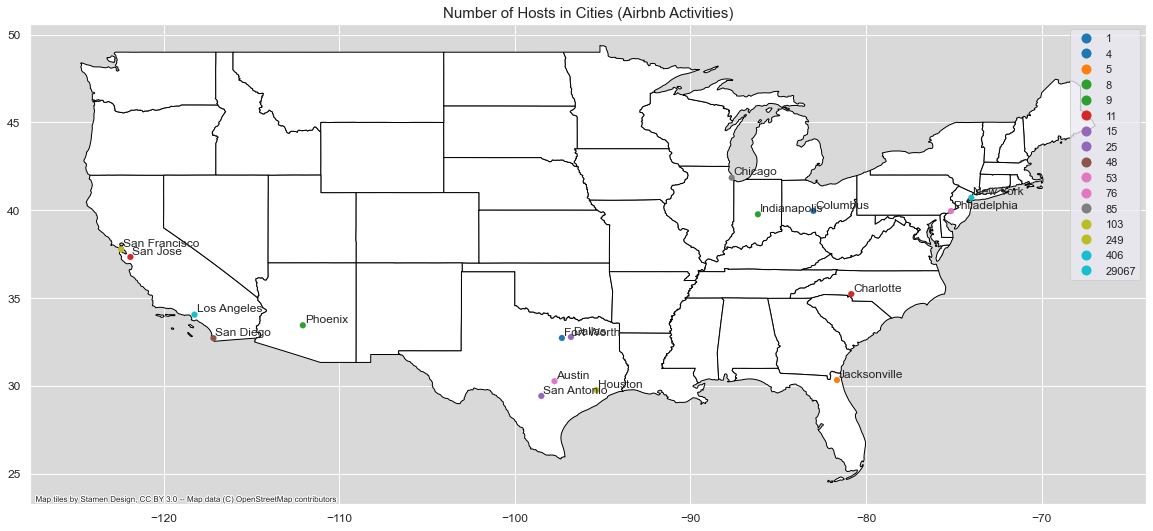

In [71]:
fig, ax = plt.subplots(figsize = (20, 10), subplot_kw = {'aspect':'equal'})
state_scale.plot(ax = ax, color = 'white', edgecolor = 'black')
City.plot(ax = ax, column = 'N_host', linewidth = 0.2, legend = True)
ctx.add_basemap(ax = ax, zoom = 5, source = ctx.providers.Stamen.TonerLite)
for x, y, label in zip(City.geometry.x, City.geometry.y, City.City):
    ax.annotate(label, xy = (x, y), xytext = (2, 3), textcoords = 'offset points', fontsize = 12)
ax.figure.axes[0].tick_params(labelsize = 12)

ax.set_title('Number of Hosts in Cities (Airbnb Activities)', fontsize = 15)
City.sort_values(by = 'N_host', ascending = False)

In this dataset, most hosts are in New York and Los Angeles, the two most populated cities in US.

## Differences in the Review Score - Values

Plot the average **'review_scores_value'** for major US cities to see if there is any difference among them.

Text(0.5, 1.0, 'Scores of Values in Major US Cities')

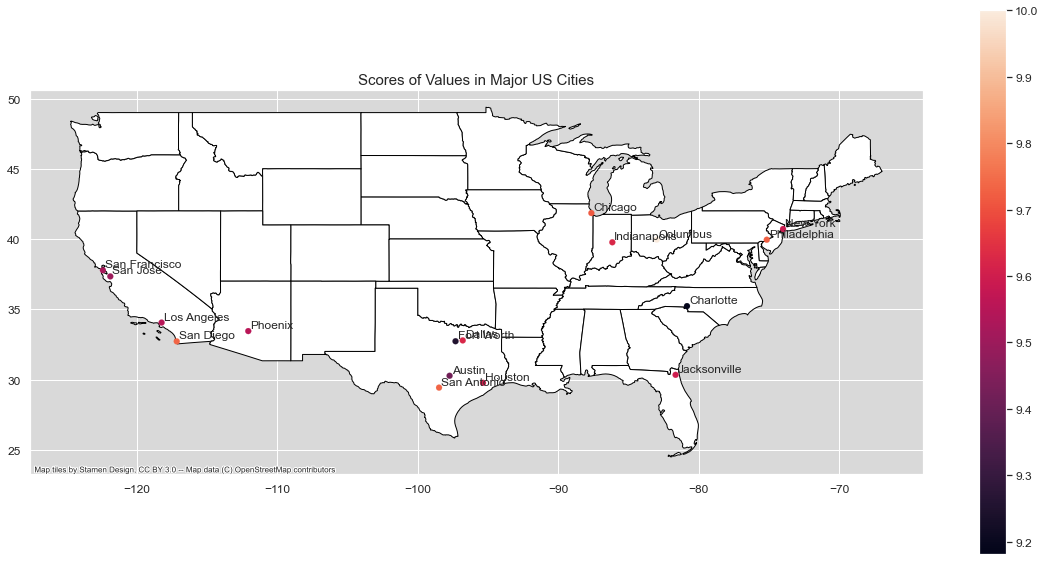

In [72]:
City['Avg Value'] = None
for c in Anblist.groupby(by = 'host_location'):
    City.loc[City['City'] == c[0], 'Avg Value'] = c[1]['review_scores_value'].mean()

City['Avg Value'] = City['Avg Value'].astype('float')
fig, ax = plt.subplots(figsize = (20, 10), subplot_kw = {'aspect':'equal'})
state_scale.plot(ax = ax, color = 'white', edgecolor = 'black')
City.plot(ax = ax, column = 'Avg Value', linewidth = 0.2, legend = True)
ctx.add_basemap(ax = ax, zoom = 5, source = ctx.providers.Stamen.TonerLite)
for x, y, label in zip(City.geometry.x, City.geometry.y, City.City):
    ax.annotate(label, xy = (x, y), xytext = (2, 3), textcoords = 'offset points', fontsize = 12)
ax.figure.axes[0].tick_params(labelsize = 12)
ax.figure.axes[1].tick_params(labelsize = 12)

ax.set_title('Scores of Values in Major US Cities', fontsize = 15)

There are some cities have a higher average review values, like Chicago, San Diego and Philadelphia.